Streaming output truncated to the last 5000 lines.
  inflating: dataset/train/0/9686834R.png  
  inflating: dataset/train/0/9686908L.png  
  inflating: dataset/train/0/9686908R.png  
  inflating: dataset/train/0/9687273L.png  
  inflating: dataset/train/0/9689906R.png  
  inflating: dataset/train/0/9690910L.png  
  inflating: dataset/train/0/9690910R.png  
  inflating: dataset/train/0/9691359L.png  
  inflating: dataset/train/0/9691359R.png  
  inflating: dataset/train/0/9692163L.png  
  inflating: dataset/train/0/9692604L.png  
  inflating: dataset/train/0/9692604R.png  
  inflating: dataset/train/0/9692923R.png  
  inflating: dataset/train/0/9693364R.png  
  inflating: dataset/train/0/9693599L.png  
  inflating: dataset/train/0/9693599R.png  
  inflating: dataset/train/0/9694101L.png  
  inflating: dataset/train/0/9694101R.png  
  inflating: dataset/train/0/9695317L.png  
  inflating: dataset/train/0/9695317R.png  
  inflating: dataset/train/0/9695621L.png  
  inflating: dataset/trai

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 138s 578ms/step - accuracy: 0.3496 - loss: 1.5949 - val_accuracy: 0.4661 - val_loss: 1.2487 - learning_rate: 0.0010
Epoch 2/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 40s 219ms/step - accuracy: 0.4287 - loss: 1.3300 - val_accuracy: 0.4879 - val_loss: 1.2390 - learning_rate: 0.0010
Epoch 3/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 39s 216ms/step - accuracy: 0.4478 - loss: 1.2616 - val_accuracy: 0.4770 - val_loss: 1.1897 - learning_rate: 0.0010
Epoch 4/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 39s 216ms/step - accuracy: 0.4765 - loss: 1.2161 - val_accuracy: 0.4818 - val_loss: 1.2531 - learning_rate: 0.0010
Epoch 5/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 40s 222ms/step - accuracy: 0.4676 - loss: 1.2200 - val_accuracy: 0.4818 - val_loss: 1.2122 - learning_rate: 0.0010
Epoch 6/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 39s 215ms/step - accuracy: 0.4877 - loss: 1.1740 - val_accuracy: 0.4927 - val_loss: 1.1834 - learning_rate: 2.0000e-04
Epoch 7/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 39s 217ms/step - accuracy

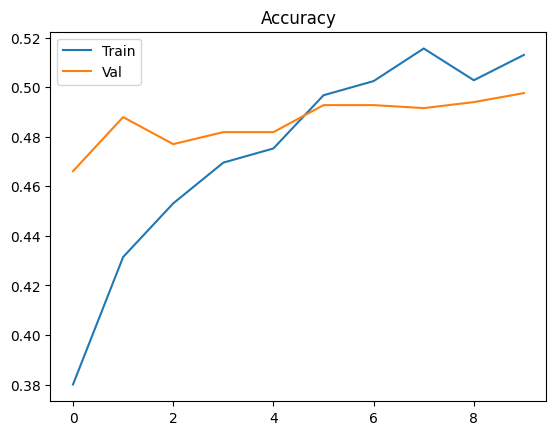

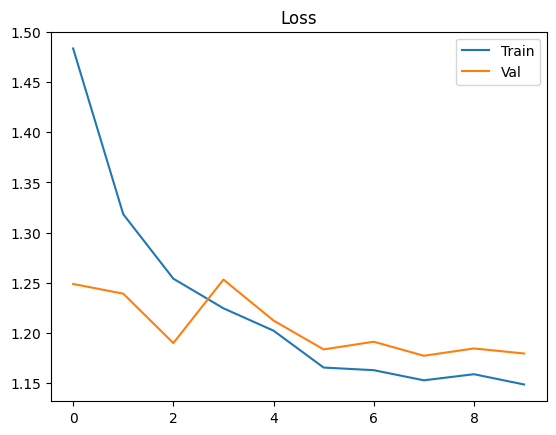

In [2]:
# ===== CELL 1: TRAIN MODEL FAST =====
import os, numpy as np, matplotlib.pyplot as plt, seaborn as sns, tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import mixed_precision




!pip install kaggle
from google.colab import files
files.upload()  # upload your kaggle.json

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d shashwatwork/knee-osteoarthritis-dataset-with-severity
!unzip knee-osteoarthritis-dataset-with-severity.zip -d dataset


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.15  # 15% for validation
)

train_gen = train_datagen.flow_from_directory(
    'dataset',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_gen = train_datagen.flow_from_directory(
    'dataset',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)


# ===== SPEED BOOST =====
mixed_precision.set_global_policy('mixed_float16')

# ===== PATHS =====
train_dir = "dataset/train"
val_dir   = "dataset/val"

IMG_SIZE = 160
BATCH_SIZE = 32

# ===== DATA =====
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir, target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE, class_mode='categorical'
)
val_gen = val_datagen.flow_from_directory(
    val_dir, target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE, class_mode='categorical',
    shuffle=False
)

# ===== MODEL =====
base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
base_model.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.3)(x)
output = Dense(5, activation='softmax', dtype='float32')(x)

model = Model(base_model.input, output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# ===== CALLBACKS =====
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)

# ===== TRAIN =====
history = model.fit(train_gen, validation_data=val_gen, epochs=10,
                    callbacks=[early_stop, reduce_lr])

# ===== TRAINING CURVES =====
plt.figure(); plt.plot(history.history['accuracy'], label='Train'); plt.plot(history.history['val_accuracy'], label='Val'); plt.title("Accuracy"); plt.legend(); plt.show()
plt.figure(); plt.plot(history.history['loss'], label='Train'); plt.plot(history.history['val_loss'], label='Val'); plt.title("Loss"); plt.legend(); plt.show()


Saving WhatsApp Image 2026-02-14 at 10.12.45 AM.jpeg to WhatsApp Image 2026-02-14 at 10.12.45 AM.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 23s 23s/step
Predicted KL Grade: 4
Class Probabilities: [0.03608463 0.02311837 0.08091093 0.14268918 0.71719694]


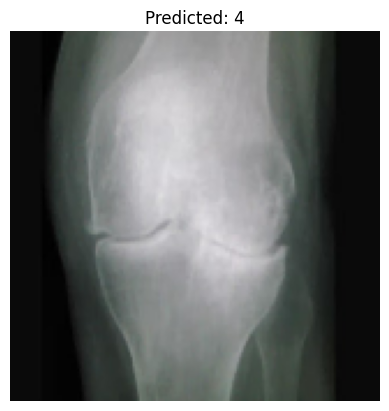

In [3]:
# ===== CELL 2: UPLOAD & PREDICT =====
from google.colab import files
uploaded = files.upload()

img_path = list(uploaded.keys())[0]
IMG_SIZE = 160

from tensorflow.keras.preprocessing import image
import numpy as np

# Load & preprocess
img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
img_array = image.img_to_array(img)/255.0
img_array = np.expand_dims(img_array, axis=0)

# Predict
preds = model.predict(img_array)
pred_class = np.argmax(preds[0])
class_names = list(train_gen.class_indices.keys())
pred_label = class_names[pred_class]

print("Predicted KL Grade:", pred_label)
print("Class Probabilities:", preds[0])

# Show image
import matplotlib.pyplot as plt
plt.imshow(img)
plt.title(f"Predicted: {pred_label}")
plt.axis('off')
plt.show()


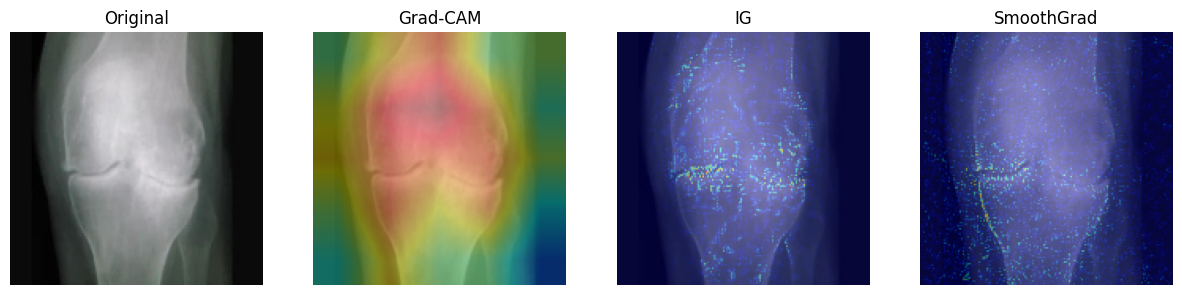

In [9]:
# ===== CELL 3 FIXED: XAI COMPARISON =====
import cv2, tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Ensure img_array is float32 and has batch dimension
img_array = tf.convert_to_tensor(img_array, dtype=tf.float32)

# Last conv layer for MobileNetV2
last_conv = "Conv_1"  # works for MobileNetV2

# Grad-CAM
def gradcam(img_array):
    grad_model = tf.keras.models.Model(model.inputs,
                                       [model.get_layer(last_conv).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, tf.argmax(predictions[0])]
    grads = tape.gradient(loss, conv_outputs)
    pooled = tf.reduce_mean(grads, axis=(0,1,2))
    heatmap = tf.reduce_sum(conv_outputs[0]*pooled, axis=-1)
    heatmap = tf.maximum(heatmap,0)/tf.reduce_max(heatmap+1e-8)
    return heatmap.numpy()

# Integrated Gradients
def integrated_gradients(img_array, steps=30):
    img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)
    baseline = tf.zeros_like(img_tensor)
    avg_grads = tf.zeros_like(img_tensor)
    for i in range(steps+1):
        interp = baseline + (i/steps)*(img_tensor-baseline)
        with tf.GradientTape() as tape:
            tape.watch(interp)
            preds = model(interp)
            loss = preds[:, tf.argmax(preds[0])]
        grads = tape.gradient(loss, interp)
        avg_grads += grads
    ig = (img_tensor-baseline)*avg_grads/steps
    ig = tf.reduce_sum(tf.maximum(ig[0],0), axis=-1)
    ig /= tf.reduce_max(ig+1e-8)
    return ig.numpy()

# SmoothGrad
def smoothgrad(img_array, samples=15, noise=0.05):
    img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)
    grads_sum = tf.zeros_like(img_tensor)
    for _ in range(samples):
        noise_img = img_tensor + noise*tf.random.normal(shape=img_tensor.shape)
        with tf.GradientTape() as tape:
            tape.watch(noise_img)
            preds = model(noise_img)
            loss = preds[:, tf.argmax(preds[0])]
        grads = tape.gradient(loss, noise_img)
        grads_sum += grads
    sg = tf.reduce_sum(tf.maximum(tf.reduce_mean(grads_sum, axis=0),0), axis=-1)
    sg /= tf.reduce_max(sg+1e-8)
    return sg.numpy()

# Compute heatmaps
cam_map = gradcam(img_array)
ig_map  = integrated_gradients(img_array)
sg_map  = smoothgrad(img_array)

# Resize for overlay
cam = cv2.resize(cam_map.astype(np.float32), (IMG_SIZE, IMG_SIZE))
ig  = cv2.resize(ig_map.astype(np.float32), (IMG_SIZE, IMG_SIZE))
sg  = cv2.resize(sg_map.astype(np.float32), (IMG_SIZE, IMG_SIZE))

# Overlay function
def overlay_map(img_path, heatmap):
    orig = cv2.imread(img_path)
    orig = cv2.resize(orig,(IMG_SIZE,IMG_SIZE))
    heatmap = np.uint8(255*heatmap)
    colored = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    return cv2.addWeighted(orig,0.6,colored,0.4,0)

overlay_cam = overlay_map(img_path, cam)
overlay_ig  = overlay_map(img_path, ig)
overlay_sg  = overlay_map(img_path, sg)

# Plot comparison
plt.figure(figsize=(15,5))
plt.subplot(1,4,1); plt.imshow(img); plt.title("Original"); plt.axis('off')
plt.subplot(1,4,2); plt.imshow(cv2.cvtColor(overlay_cam,cv2.COLOR_BGR2RGB)); plt.title("Grad-CAM"); plt.axis('off')
plt.subplot(1,4,3); plt.imshow(cv2.cvtColor(overlay_ig,cv2.COLOR_BGR2RGB)); plt.title("IG"); plt.axis('off')
plt.subplot(1,4,4); plt.imshow(cv2.cvtColor(overlay_sg,cv2.COLOR_BGR2RGB)); plt.title("SmoothGrad"); plt.axis('off')
plt.show()


26/26 ━━━━━━━━━━━━━━━━━━━━ 28s 552ms/step


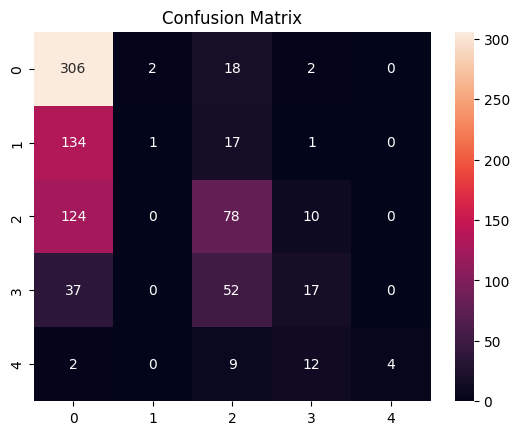

              precision    recall  f1-score   support

           0       0.51      0.93      0.66       328
           1       0.33      0.01      0.01       153
           2       0.45      0.37      0.40       212
           3       0.40      0.16      0.23       106
           4       1.00      0.15      0.26        27

    accuracy                           0.49       826
   macro avg       0.54      0.32      0.31       826
weighted avg       0.46      0.49      0.41       826



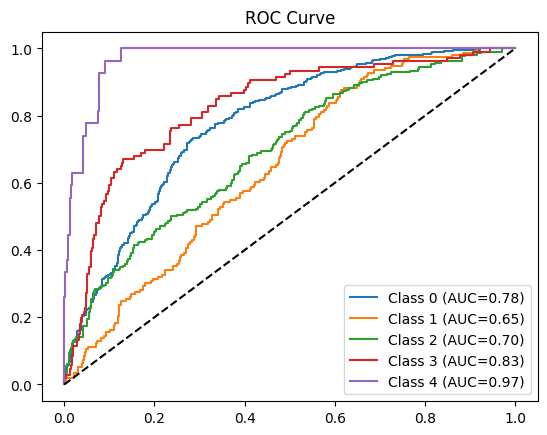

In [5]:
# ===== CELL 4: METRICS & ROC =====
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize

val_gen.reset()
y_pred = model.predict(val_gen)
y_true = val_gen.classes
y_pred_classes = np.argmax(y_pred,axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(); sns.heatmap(cm,annot=True,fmt='d'); plt.title("Confusion Matrix"); plt.show()

# Classification report
print(classification_report(y_true,y_pred_classes))

# ROC & AUC
y_true_bin = label_binarize(y_true, classes=[0,1,2,3,4])
plt.figure()
for i in range(5):
    fpr,tpr,_ = roc_curve(y_true_bin[:,i], y_pred[:,i])
    plt.plot(fpr,tpr,label=f"Class {i} (AUC={auc(fpr,tpr):.2f})")
plt.plot([0,1],[0,1],'k--')
plt.legend(); plt.title("ROC Curve"); plt.show()


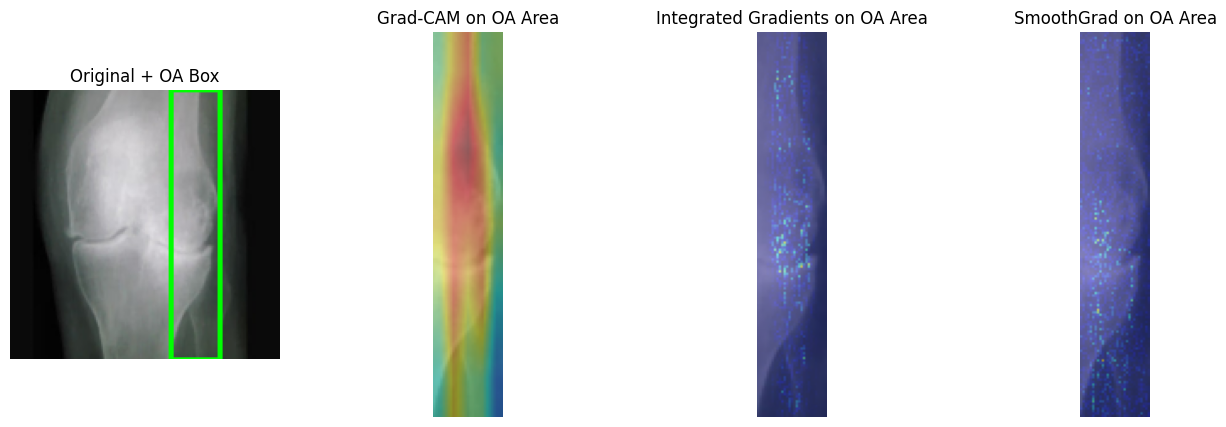

In [10]:
# ===== CELL 5: OA CARTILAGE AREA + XAI HEATMAP =====
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load original image
orig = cv2.imread(img_path)
orig = cv2.resize(orig, (IMG_SIZE, IMG_SIZE))

# Convert to grayscale
gray = cv2.cvtColor(orig, cv2.COLOR_BGR2GRAY)

# Use Canny edges to roughly detect joint narrowing
edges = cv2.Canny(gray, 50, 150)
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Pick largest contour (rough approximation of joint area)
largest = max(contours, key=cv2.contourArea)
x, y, w, h = cv2.boundingRect(largest)

# Draw bounding box on original image
boxed_img = orig.copy()
cv2.rectangle(boxed_img, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Crop original image for overlay
crop_orig = orig[y:y + h, x:x + w]

# Resize XAI heatmaps to fit the crop
cam_crop = cv2.resize(cam, (w, h))
ig_crop  = cv2.resize(ig, (w, h))
sg_crop  = cv2.resize(sg, (w, h))

# Overlay function
def overlay_heatmap(base_img, heatmap):
    heatmap = np.uint8(255 * heatmap)
    colored = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)  # Jet color highlights OA area
    return cv2.addWeighted(base_img, 0.6, colored, 0.4, 0)

# Apply overlay
overlay_cam_crop = overlay_heatmap(crop_orig, cam_crop)
overlay_ig_crop  = overlay_heatmap(crop_orig, ig_crop)
overlay_sg_crop  = overlay_heatmap(crop_orig, sg_crop)

# Plot all together
plt.figure(figsize=(16,5))

plt.subplot(1,4,1)
plt.imshow(cv2.cvtColor(boxed_img, cv2.COLOR_BGR2RGB))
plt.title("Original + OA Box")
plt.axis('off')

plt.subplot(1,4,2)
plt.imshow(cv2.cvtColor(overlay_cam_crop, cv2.COLOR_BGR2RGB))
plt.title("Grad-CAM on OA Area")
plt.axis('off')

plt.subplot(1,4,3)
plt.imshow(cv2.cvtColor(overlay_ig_crop, cv2.COLOR_BGR2RGB))
plt.title("Integrated Gradients on OA Area")
plt.axis('off')

plt.subplot(1,4,4)
plt.imshow(cv2.cvtColor(overlay_sg_crop, cv2.COLOR_BGR2RGB))
plt.title("SmoothGrad on OA Area")
plt.axis('off')

plt.show()


Average heatmap intensity in ROI:
Grad-CAM    : 0.793499
IG          : 0.07368007
SmoothGrad  : 0.052737642
Consensus   : 0.45896327


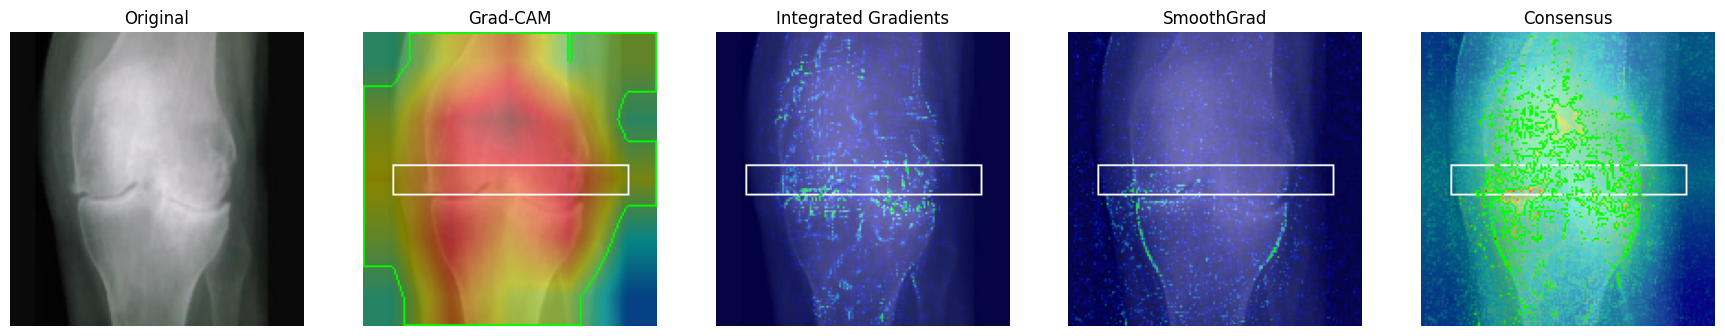

In [16]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# ==================== CONFIG ====================
# Make sure IMG_SIZE and model are defined
# img_resized should be your input image resized to (IMG_SIZE, IMG_SIZE, 3)
# roi_mask should be defined with the ROI as 1, else 0
# roi_coords = (x_start, y_start, x_end, y_end)

# ==================== XAI FUNCTIONS ====================

def gradcam(img_tensor, model, layer_name=None, target_size=(IMG_SIZE, IMG_SIZE)):
    """Compute Grad-CAM heatmap."""
    if layer_name is None:
        for layer in reversed(model.layers):
            if isinstance(layer, tf.keras.layers.Conv2D):
                layer_name = layer.name
                break
    if layer_name is None:
        raise ValueError("No Conv2D layer found in model for Grad-CAM.")

    grad_model = tf.keras.models.Model(
        model.input,
        [model.get_layer(layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, preds = grad_model(img_tensor)
        loss = preds[:, tf.argmax(preds[0])]
    grads = tape.gradient(loss, conv_outputs)
    pooled = tf.reduce_mean(grads, axis=(0,1,2))
    heatmap = tf.reduce_sum(conv_outputs[0]*pooled, axis=-1)
    heatmap = tf.maximum(heatmap,0)

    heatmap = tf.expand_dims(heatmap,-1)
    heatmap_resized = tf.image.resize(heatmap, target_size)
    heatmap_resized = tf.squeeze(heatmap_resized)
    max_val = tf.reduce_max(heatmap_resized)
    if max_val > 0:
        heatmap_resized /= max_val
    return heatmap_resized.numpy()

def integrated_gradients(img_tensor, model, steps=30, target_size=(IMG_SIZE, IMG_SIZE)):
    """Compute Integrated Gradients heatmap."""
    baseline = tf.zeros_like(img_tensor)
    avg_grads = tf.zeros_like(img_tensor)
    for i in range(steps+1):
        interp = baseline + (i/steps)*(img_tensor-baseline)
        with tf.GradientTape() as tape:
            tape.watch(interp)
            preds = model(interp)
            loss = preds[:, tf.argmax(preds[0])]
        grads = tape.gradient(loss, interp)
        avg_grads += grads
    ig = (img_tensor - baseline)*avg_grads/steps
    ig = tf.reduce_sum(tf.maximum(ig[0],0), axis=-1)
    ig = tf.expand_dims(ig,-1)
    ig_resized = tf.image.resize(ig, target_size)
    ig_resized = tf.squeeze(ig_resized)
    max_val = tf.reduce_max(ig_resized)
    if max_val > 0:
        ig_resized /= max_val
    return ig_resized.numpy()

def smoothgrad(img_tensor, model, samples=15, noise=0.05, target_size=(IMG_SIZE, IMG_SIZE)):
    """Compute SmoothGrad heatmap."""
    grads_sum = tf.zeros_like(img_tensor)
    for _ in range(samples):
        noise_img = img_tensor + noise*tf.random.normal(shape=img_tensor.shape)
        with tf.GradientTape() as tape:
            tape.watch(noise_img)
            preds = model(noise_img)
            loss = preds[:, tf.argmax(preds[0])]
        grads = tape.gradient(loss, noise_img)
        grads_sum += grads
    sg = tf.reduce_sum(tf.maximum(tf.reduce_mean(grads_sum, axis=0),0), axis=-1)
    sg = tf.expand_dims(sg,-1)
    sg_resized = tf.image.resize(sg, target_size)
    sg_resized = tf.squeeze(sg_resized)
    max_val = tf.reduce_max(sg_resized)
    if max_val > 0:
        sg_resized /= max_val
    return sg_resized.numpy()

# ==================== OVERLAY FUNCTION ====================

def overlay_map(img_rgb, heatmap, alpha=0.5, roi_coords=None):
    """Overlay a heatmap on the image with optional ROI rectangle and contours."""
    # Ensure img_rgb is uint8
    if img_rgb.dtype != np.uint8:
        img_rgb_uint8 = np.uint8(255*np.clip(img_rgb,0,1))
    else:
        img_rgb_uint8 = img_rgb.copy()

    # Heatmap to RGB
    heatmap_uint = np.uint8(255*np.clip(heatmap,0,1))
    colored = cv2.applyColorMap(heatmap_uint, cv2.COLORMAP_JET)
    colored = cv2.cvtColor(colored, cv2.COLOR_BGR2RGB)

    # Match shapes
    if colored.shape != img_rgb_uint8.shape:
        colored = cv2.resize(colored, (img_rgb_uint8.shape[1], img_rgb_uint8.shape[0]))

    overlay = cv2.addWeighted(img_rgb_uint8, 1-alpha, colored, alpha, 0)

    # Draw ROI
    if roi_coords is not None:
        x_start, y_start, x_end, y_end = roi_coords
        cv2.rectangle(overlay, (x_start, y_start), (x_end, y_end), (255,255,255),1)

    # Draw contours for strong regions
    thresh = np.uint8(heatmap>0.5)*255
    contours,_ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(overlay, contours, -1, (0,255,0),1)

    return overlay

# ==================== COMPUTE HEATMAPS ====================

cam_map = gradcam(img_tensor, model)
ig_map  = integrated_gradients(img_tensor, model)
sg_map  = smoothgrad(img_tensor, model)

consensus_map = (cam_map + ig_map + sg_map)/3.0
if np.max(consensus_map)>0:
    consensus_map /= np.max(consensus_map)

# ==================== ROI METRICS ====================

def roi_intensity(heatmap, mask):
    return np.sum(heatmap*mask)/np.sum(mask) if np.sum(mask)>0 else 0.0

print("Average heatmap intensity in ROI:")
print("Grad-CAM    :", roi_intensity(cam_map, roi_mask))
print("IG          :", roi_intensity(ig_map, roi_mask))
print("SmoothGrad  :", roi_intensity(sg_map, roi_mask))
print("Consensus   :", roi_intensity(consensus_map, roi_mask))

# ==================== OVERLAY IMAGES ====================

overlay_cam       = overlay_map(img_resized, cam_map, roi_coords=roi_coords)
overlay_ig        = overlay_map(img_resized, ig_map, roi_coords=roi_coords)
overlay_sg        = overlay_map(img_resized, sg_map, roi_coords=roi_coords)
overlay_consensus = overlay_map(img_resized, consensus_map, roi_coords=roi_coords)

# ==================== PLOT ====================

plt.figure(figsize=(22,5))
plt.subplot(1,5,1); plt.imshow(img_resized); plt.title("Original"); plt.axis('off')
plt.subplot(1,5,2); plt.imshow(overlay_cam); plt.title("Grad-CAM"); plt.axis('off')
plt.subplot(1,5,3); plt.imshow(overlay_ig); plt.title("Integrated Gradients"); plt.axis('off')
plt.subplot(1,5,4); plt.imshow(overlay_sg); plt.title("SmoothGrad"); plt.axis('off')
plt.subplot(1,5,5); plt.imshow(overlay_consensus); plt.title("Consensus"); plt.axis('off')
plt.show()
